
TFG

Este es el codigo del tfg de Borja Jimeno

En esta primera celda vamos a definir todas las funciones y variables que necesitaremos para calcular el ritmo teórico. Cada función está explicada al inicio y cada variable tiene asociadas sus unidades en un comentario a la derecha.  

Para la realización de las funciones se ha tomado como referencia:  
-El pdf ('rateTutorial_MMartinez_TAE25.pdf)    
-El capítulo 7 de la Tesis de María ('tesisMaria_chap7.pdf')   
-El artículo 'Inelastic and Elastic Scattering of 187-Mev Electrons from Selected Even-Even Nuclei - Richard Helm - PHISICAL REVIEW VOLUME 104, NUMBER 5 DECEMBER 1, 1956'  
-Para calcular el Quenching Factor, Sección 4.3.2 de la tesis de Tamara Pardo Yanguas ('Tesis-Tamara.pdf')

In [1]:
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm

plt.rcParams['font.size'] = 18

unitsvearth = 0 # km/s -> 0 , m/s -> 1

#ctes

mn=0.9315               # Masa nucleon (GeV/c^2)
NA=6.022e23             # Numero de Avogadro
c=299792458             # Velocidad luz (m/)s
hbar = 6.582e-16        # eV*s
sqrtpi=m.sqrt(m.pi)     # Raíz de pi

#Halo DM
rho=0.3                 # Densidad local de materia oscura Gev/c2/cm3
vesc=544                # Velocidad de escape de la galaxia (km/s)

#Velocidad del sol
u1=np.array([ 0.9941, 0.1088, 0.0042])
u2=np.array([-0.0504, 0.4946, -0.8677])
v0=np.array([0,238,0])                      # Velocidad en reposo local standar (km/s)
v0n=np.sqrt(v0.dot(v0))                     # Norma de la Velocidad en reposo local standar (km/s)
omega=0.0172                                # Frecuencia angular en d-1 (2pi/365)
vpec=np.array([11.1,12.2,7.3])              # Velocidad peculiar (km/s)
vsun=v0+vpec                                # Velocidad del Sol (km/s)
vorb=29.8                                   # Velocidad orbital de la Tierra (km/s)
timeMax=72.9                                # Dia de la máxima velocidad de la tierra: 2 de junio, empezando desde el 22 de marzo.
timeMin=255.5                               # Dia de la mínima velocidad de la tierra: empezando desde el 22 de marzo.
timeAvg=(timeMax+timeMin)/2.                # Dia promedio (El que usaremos para calcular el ritmo)
ene=np.arange(0,100,1)                      # Array de energías de 0 a 100 MeV en intervalos de 1 MeV
time=np.arange(0,365,1)                     # Array de dias, 365 dias en intervalos de 1 dia




#################
# Funcion de Bessel de primera especie
#################
def j1(x):
    return(m.sin(x)/(x*x)-m.cos(x)/x)

#################
# Velocidad de la tierra, en km/s
#################
def vearth(t): 
    v = vsun + vorb*(m.cos(omega*t)*u1+m.sin(omega*t)*u2)
    return m.sqrt(v.dot(v))
    
#################
# Velocidad minima de la DM para un umbral E (en km/s)
# E en keV
# A: Numero másico
# mW: Masa del Wimp en GeV/c^2
#################
def vmin(E,A,mW): 
    res=E*1e-6*(A*mn+mW)*(A*mn+mW)/(2*A*mn*mW*mW)
    res=np.sqrt(res)*c/1000
    return res

#################
# mean inverse speed function (Función de velocidad inversa media) (en s/km)
# E en keV
# t: Tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
#################
def eta(E,t,A,mW):
    x=vmin(E,A,mW)/v0n
    y=vearth(t)/v0n
    z=vesc/v0n
    if(x>(z+y)): 
        return 0
    else:
        N=m.erf(z)-2*z/np.sqrt(np.pi)*m.exp(-z*z)
        if((x>(z-y)) and ((z+y) >= x)):
            return 1/(2*y*v0n*N)*(m.erf(z)-m.erf(x-y)-2/np.sqrt(np.pi)*(z+y-x)*np.exp(-z*z))
        if((x>=(0)) and ((z-y) >= x)):
            return 1/(2*y*v0n*N)*(m.erf(x+y)-m.erf(x-y)-4/np.sqrt(np.pi)*y*np.exp(-z*z))
        
#################
# Factor de Forma
# E en keV
# A: Numero másico
#################
def FF(E,A):
    if E==0:
        E=1e-12
    s=1
    R=1.2*A**(0.3333)
    
    R1=m.sqrt(R*R-5*s*s)
    R1*=1e-6/hbar/c

    q2=2*E*A*mn*1e-6
    x=m.sqrt(q2)*R1
    aux=q2*s*s*1e-6/hbar/c*1e-6/hbar/c
    F2=((3*j1(x)/(x))**2)*m.exp(-aux)
    return F2

#################
# Ritmo diferencial
# E en keV
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
#################
def rate(E,t,A,mW,sigmaSI):
    mN=A*mn
    Mdet=NA*mN*1000 # GeV/c2/kg
    mu_n=mW*mn/(mW+mn)
    retval=Mdet*rho/2./mW*A*A/mu_n/mu_n*sigmaSI*c*c
    retval*=8.64e-3 # to convert to counts/kg/keV/d
    retval*=365 # convert to counts/kg/keV/y
    retval*=FF(E,A)
    retval*=eta(E,t,A,mW)
    return retval

#########################
#########################
# Ritmo total, integrado entre Ei y Ef (en c/kg/y)
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def totalRate(Ei,Ef,t,A,mW,sigmaSI):
  ene=np.arange(Ei,Ef,0.1)
  rates=np.array([rate(e,t,A,mW,sigmaSI) for e in ene])
  return rates.sum()*0.1

#########################
#########################
# Ritmo en funcon del tiempo
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def ratevsTime(Ei,Ef,A,mW,sigmaSI):
    dias = np.arange(0,365)
    ritmos_dias=([totalRate(Ei,Ef,t,A,mW,sigmaSI) for t in dias])
    return ritmos_dias



# FUNCIONES ESPECIFICAS PARA NAI

#########################
#########################
# Ritmo en funcon del tiempo
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def ratevsTimeNaI(Ei,Ef,mW,sigmaSI):
    dias = np.arange(0,365)
    ritmos_dias=([totalRateNaI(Ei,Ef,t,mW,sigmaSI) for t in dias])
    return ritmos_dias
       
#########################
#########################
# Ritmo total, integrado entre Ei y Ef (en c/kg/y)
# Ei, Ef: Energias inicial y final en keV
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def totalRateNaI(Ei,Ef,t,mW,sigmaSI):
  ene=np.arange(Ei,Ef,0.1)
  rates=np.array([RateNaI(e,t,mW,sigmaSI) for e in ene])
  return rates.sum()*0.1

#########################
#########################
# Ritmo diferencial
# E en keV
# t: tiempo en dias desde el 22 de marzo
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def RateNaI(E,t,mW,sigmaSI):
    ratesNa=rate(E,t,23,mW,sigmaSI)
    ratesI=rate(E,t,127,mW,sigmaSI)
    return (23.*ratesNa+127.*ratesI)/(23.+127.)


# FUNCIONES TENIENDO EN CUENTA EL FACTOR QUENCHING

#FACTOR QUENCHING
#   Devuelve el factor quenching del NaI evaluado en electron-equivalent energy ee
#   Parametros
# ee : float o array-like de Electron-equivalent energy.
# Devuelve: float or np.ndarray
# Quenching factor QF(ee), interpolado linealmente en (x=ER*QF, y=QF)
# Construido para ER in [1, 100] with N=200 points.
# From modified Lindhard Fit of Na QF data (Tamara's thesis)
# k = 0.072, alpha = 0.007
# epsilon = alpha * ER
# g(ER)=3*pow(epsilon, 0.15) + 0.7*pow(epsilon,0.6) + epsilon
# QF(ER)=k*g(ER)/(1+k*g(ER))
# Eee=ER*QF(ER)

def getQFNa(ee, k=0.072, alpha=0.007, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)
    epsilon = alpha * ER
    g = 3.0 * epsilon**0.15 + 0.7 * epsilon**0.6 + epsilon
    qf = (k * g) / (1.0 + k * g)

    # Graph: x = ER * qf (== ee), y = qf
    x = ER * qf
    y = qf

    # Interpolate y at the provided ee values.
    # For values outside the tabulated range, clamp to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])

    return y_interp[0] if np.isscalar(ee) else y_interp

def getQFI(ee, p0=0.03, p1=0.0006, limit=80.0, N=200, ER_min=1.0, ER_max=100.0):
    # calculate QF(ER) for interval ER_min, ER_max
    ER = np.linspace(ER_min, ER_max, N)

    # Piecewise-linear QF(ER)
    qf = p0 + p1 * np.minimum(ER, limit)

    # Graph x = ER * QF(ER), y = QF(ER)
    x = ER * qf
    y = qf

    # Interpolate y at ee; clamp outside domain to the nearest endpoint
    ee_arr = np.atleast_1d(ee).astype(float)
    y_interp = np.interp(ee_arr, x, y, left=y[0], right=y[-1])

    return y_interp[0] if np.isscalar(ee) else y_interp

#################
# Ritmo diferencial (Teniendo en cuenta el Quenching, Energía en ee)
# E en keV
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
#################
def rate_ee(Eee,t,A,mW,sigmaSI,Q=1):
    E=Eee/Q
    mN=A*mn
    Mdet=NA*mN*1000 # GeV/c2/kg
    mu_n=mW*mn/(mW+mn)
    retval=Mdet*rho/2./mW*A*A/mu_n/mu_n*sigmaSI*c*c
    retval*=8.64e-3 # to convert to counts/kg/keV/d
    retval*=365 # convert to counts/kg/keV/y
    retval*=FF(E,A)
    retval*=eta(E,t,A,mW)
    retval/=Q
    return retval

#########################
#########################
# Ritmo diferencial en detector NaI (en c/kevee/kg/y) 
# E: en keVee
# t: tiempo en dias desde el 22 de marzo
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
# QNa es el factor de Quenching a energía Eee(keVee) para Na
# QI es el factor de Quenching a energía Eee(keVee) para I
def rateNaI_ee(Eee,t,mW,sigmaSI, QNa=1, QI=1):
  # convert Eee to keV_NR
  rateNa = rate_ee(Eee,t,23,mW,sigmaSI,QNa)
  rateI = rate_ee(Eee,t,127,mW,sigmaSI,QI)
 
  return (rateNa*23.+rateI*127.)/(23.+127.)

#########################
#########################
# Ritmo total, integrado entre Eiee y Efee (en c/kg/y)
# Eiee, Efee: Energías inicial y final en keVee
# t: tiempo en dias desde el 22 de marzo
# A: numero masico
# mW: Masa del Wimp en GeV/c^2
# sigmaSI: Seccion eficaz spin independent en cm^2
def totalRate_NaI_ee(Eiee,Efee,t,mW,sigmaSI):
  energy_ee = np.arange(Eiee,Efee,0.1)
  qfNa = getQFNa(energy_ee)
  qfI = getQFI(energy_ee)
  rates = np.array([
        rateNaI_ee(e, t, mW, sigmaSI, qna, qi)
        for e, qna, qi in zip(energy_ee, qfNa, qfI)
    ])

  return rates.sum()*0.1


En esta sección del codigo, vamos a extraer los datos del experimento de un archivo de formato .root emplenado la libreria uproot. Los histogramas del archivo se pueden ver en la imagen siguiente:

<img src="Images/archivo_root.png" height="500">

Estos histogramas se han dibujado mediante la terminal de Root. 


Para abrirlos con Python, en primer lugar importamos el archivo con **uproot.open**. Con el comando **file.keys()**, se accede a su estructura, vemos que hay 8 histogramas en su interior.

In [2]:
import uproot
file = uproot.open("Datos/BEhistos_year123456.root")
file.keys()

['hbea_123456y_D0;1',
 'hbea_123456y_D1;1',
 'hbea_123456y_D2;1',
 'hbea_123456y_D3;1',
 'hbea_123456y_D4;1',
 'hbea_123456y_D5;1',
 'hbea_123456y_D6;1',
 'hbea_123456y_D7;1',
 'hbea_123456y_D8;1',
 'hbea_123456y;1']

Empleamos el comando: **file["Nombre_del_Histograma"].all_members** para ver el contenido de cada histograma.\
Por ejemplo en el histograma *"hbea_123456y_D0"*.

In [3]:
file["hbea_123456y_D0"].all_members

{'@fUniqueID': 0,
 '@fBits': 50332168,
 'fName': 'hbe0_year1_year6',
 'fTitle': '',
 'fLineColor': 600,
 'fLineStyle': 1,
 'fLineWidth': 2,
 'fFillColor': 0,
 'fFillStyle': 1001,
 'fMarkerColor': 600,
 'fMarkerStyle': 20,
 'fMarkerSize': 0.6000000238418579,
 'fNcells': 292,
 'fXaxis': <TAxis (version 10) at 0x7b96575c5940>,
 'fYaxis': <TAxis (version 10) at 0x7b96575c5df0>,
 'fZaxis': <TAxis (version 10) at 0x7b96575d91c0>,
 'fBarOffset': 0,
 'fBarWidth': 1000,
 'fEntries': 1802461.691594407,
 'fTsumw': 751.0752220746325,
 'fTsumw2': 0.3131543994404597,
 'fTsumwx': 9198.823684529332,
 'fTsumwx2': 166183.86047925722,
 'fMaximum': 16.0,
 'fMinimum': 0.0,
 'fNormFactor': 0.0,
 'fContour': <TArrayD [] at 0x7b96575d94f0>,
 'fSumw2': <TArrayD [0, 0.0131034, 0.00679434, ..., 0.000616966, 0.000634182, 0] at 0x7b96575d9520>,
 'fOption': <TString '' at 0x7b96575f2120>,
 'fFunctions': <TList of 0 items at 0x7b96575d9610>,
 'fBufferSize': 0,
 'fBuffer': array([], dtype=float64),
 'fBinStatErrOpt':

Empleamos el comando **file["Nombre_del_Histograma"].axis().edges()** para ver el valor del eje x de los bines del histograma

Empleamos el comando **file["Nombre_del_Histograma"].values()** para ver el valor del eje y de los bines del histograma

Empleamos el comando **file["Nombre_del_Histograma"].errors()** para ver el valor de la incertidumbre en el eje y de los bines del histograma

In [4]:
print(file["hbea_123456y_D0"].axis().edges())

[ 1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3
  2.4  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7
  3.8  3.9  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1
  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5
  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9
  8.   8.1  8.2  8.3  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3
  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7
 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1
 12.2 12.3 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5
 13.6 13.7 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9
 15.  15.1 15.2 15.3 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3
 16.4 16.5 16.6 16.7 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7
 17.8 17.9 18.  18.1 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1
 19.2 19.3 19.4 19.5 19.6 19.7 19.8 19.9 20.  20.1 20.2 20.3 20.4 20.5
 20.6 

In [5]:
print(file["hbea_123456y_D0"].values())

[7.7058105 7.311093  6.7740903 6.026569  5.9330454 5.458445  5.353915
 5.0994816 5.0174937 5.035382  4.987608  4.839416  4.796341  5.030872
 4.986949  5.070045  5.2279673 5.4516573 5.517425  5.688737  5.6556563
 5.677316  5.6572313 5.5827994 5.4075494 5.2673492 4.9837985 4.815637
 4.549021  4.4147277 4.19852   4.0622582 3.8799195 3.850383  3.7479897
 3.7728004 3.6365385 3.595975  3.5904615 3.5888863 3.5073655 3.5109098
 3.4415975 3.415999  3.4254508 3.3317215 3.4333272 3.415999  3.3998523
 3.396308  3.347868  3.2943084 3.387644  3.4199371 3.2880073 3.2769804
 3.2950962 3.2549264 3.2320848 3.2037299 3.229722  3.1915214 3.1489887
 3.132842  3.170255  3.1060622 3.1320543 3.0973983 3.062742  3.0639236
 3.0658927 3.0706184 3.0135145 2.990279  3.0158775 3.0056381 2.992248
 2.9906728 2.9241173 2.924511  2.8993065 2.8752835 2.8382645 2.891824
 2.814635  2.8792217 2.8288126 2.8453531 2.8288126 2.8315694 2.7173615
 2.7847047 2.8083339 2.6913693 2.705153  2.7374463 2.7063346 2.7591064
 2.7126355 

Cargamos los datos de los histogramas en un array de numpy, La estructura del array es (por columnas):  

Eje_y_H0 Error_y_H0 Eje_y_H1 Error_y_H1 ... Eje_y_H8 Error_y_H8 Eje_x  

Las unidades de los datos del histograma son cts/keV_ee/Kg/d. Definimos la funcion **carga_datos_hist**

In [6]:
def carga_datos_hist():
    file = uproot.open("/home/borja/Documents/TFG/Datos/BEhistos_year123456.root")
    file.keys()
    longitud=290
    es=np.arange(1,30,0.1)
    datos=np.zeros((19,longitud))
    for i in range (9):
        datos[2*i+1]=file["hbea_123456y_D"+str(i)].values()
        datos[2*i+2]=file["hbea_123456y_D"+str(i)].errors()
    datos[0]=es
    return datos
    #np.savetxt("Exposicion_exp.csv",datos)   
    

Imprimimos los histogramas con *matplotlib*

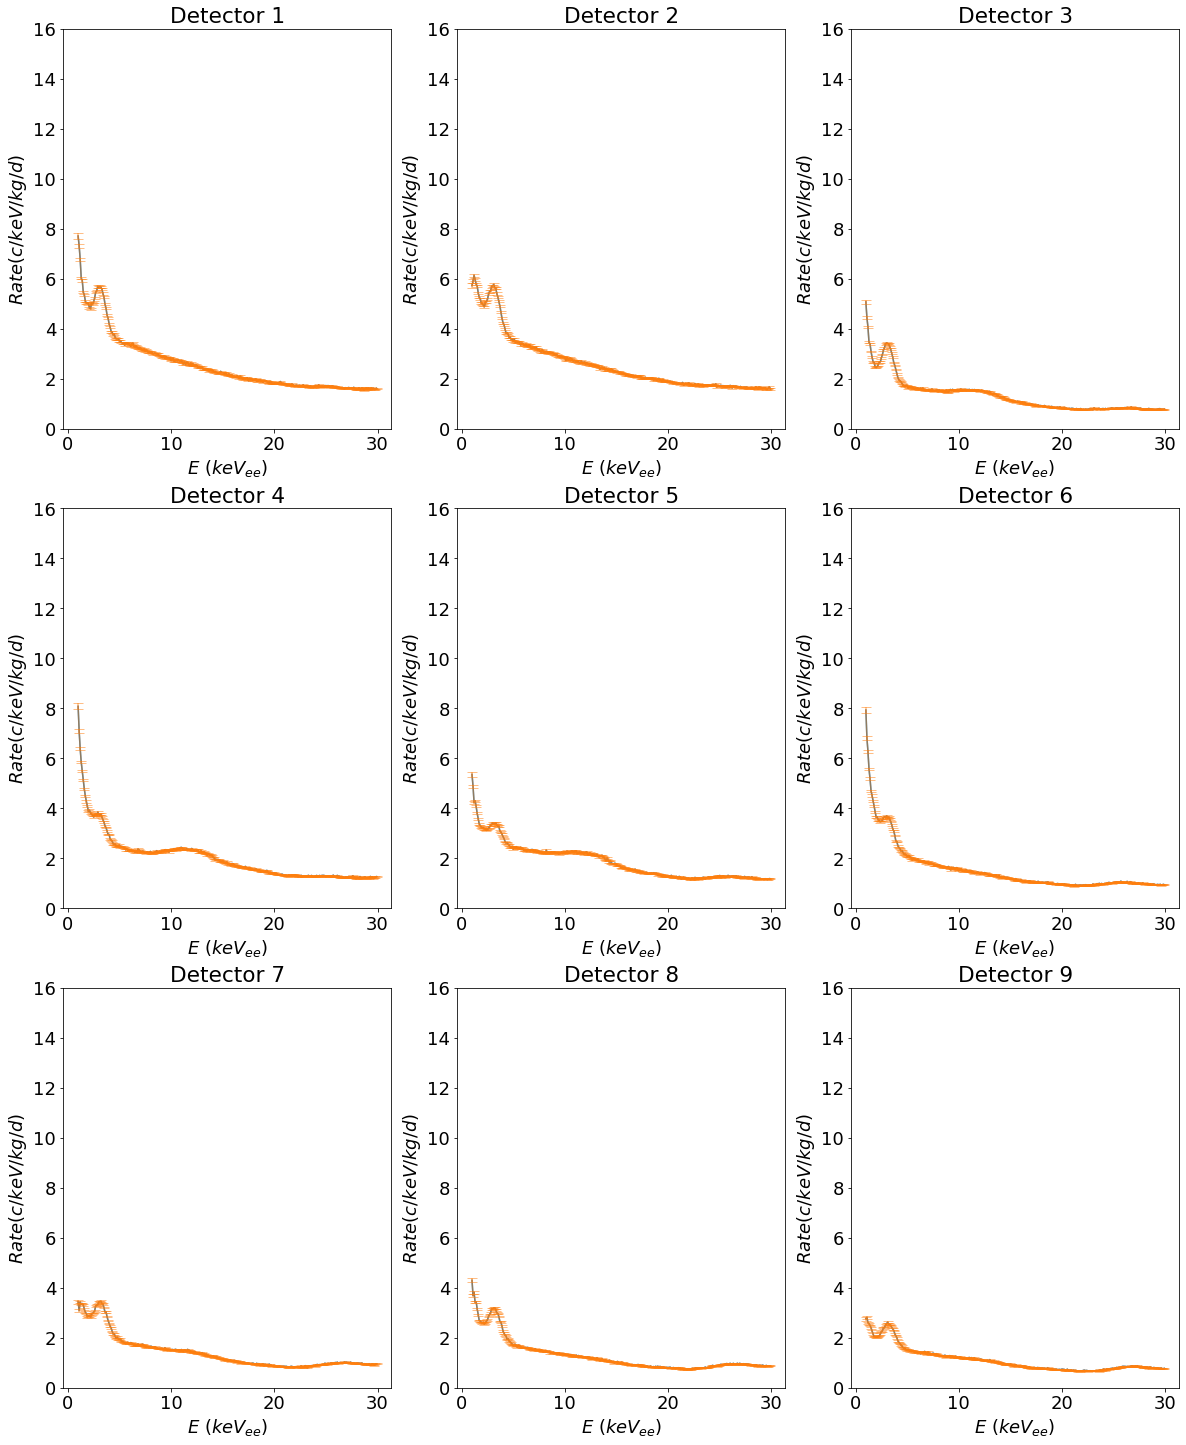

In [7]:
import numpy as np
import matplotlib.pyplot as plt

datos=carga_datos_hist()


fig, axes = plt.subplots(3, 3, figsize=(20, 25))

k=int(0)
for i in range(3):
    for j in range(3):
        axes[i, j].plot(datos[0], datos[2*k+1])
        axes[i, j].errorbar(datos[0], datos[2*k+1], yerr=datos[2*k+2], fmt='', capsize=5, alpha=0.5)
        axes[i, j].set_title(f"Detector {k+1}")
        axes[i, j].set_ylim(0,16)
        axes[i, j].set_ylabel(r'$Rate (c/keV/kg/d)$')
        axes[i, j].set_xlabel(r'$E$ ($keV_{ee}$)')
        k=k+1


plt.show()

## Ritmo

Para calcular el ritmo en el detector $j$ tenemos que sumar los valores de los bines del histograma correspondiente a ese detector y multiplicar por el ancho del bin, que en este caso es constante e igual a 0.1 keV.

$$R_j\left[  \textup{cts}\cdot d^{-1} \cdot kg^{-1}\right] = \sum_{i=E_{inf}}^{E_{sup}} \left(\frac{dR_j}{dE}\right)_i \cdot \Delta E_j = 0.1 \left[  keV\right] \cdot \sum_{i=E_{inf}}^{E_{sup}} \left(\frac{dR_j}{dE}\right)_i\left[  \textup{cts}\cdot keV^{-1}\cdot d^{-1} \cdot kg^{-1}\right]$$

Esto lo implementamos en la funcion **integral_ritmo_exp**, que nos devuelve un array de 9 valores, correspondientes al ritmo de cada uno de los 9 detectores por separado.

In [8]:
#################
# Calcula el ritmo experimental -> Resultado en (c/kg/d)
#################
# E_i: Limite inferior de la energia (keV_ee) (Minimo 1 keV_ee)
# E_f: Limite superior de la energia (keV_ee) (Maximo 30 keV_ee)
# datos: Array con los datos de los histogramas en formato
#   Eje_y_H0 Error_y_H0 Eje_y_H1 Error_y_H1 ... Eje_y_H8 Error_y_H8 Eje_x

def integral_ritmo_exp(E_i,E_f,datos):

    if(E_i<1): 
        print('El valor de E_i debe ser mayor que 1 keV_ee')
        return "El valor de E_i debe ser mayor que 1 keV_ee"
    if(E_f>30): 
        print('El valor de E_f debe ser menor que 30 keV_ee')
        return "El valor de E_f debe ser menor que 30 keV_ee"
    

    #   Hacemos la integral en el intervalo de energias definido por E_i y E_f

    ritmos_exp=np.zeros(9)

    #   Iteramos en los 9 detectores
    for i in range (9):
        ritmos_exp[i]=0

        #   Sumamos en cada detector

        for j in range(int(10*(E_i-1)),int(10*(E_f-1))):
                ritmos_exp[i]+=datos[2*i+1][j]

        #   Multiplicamos por ancho de bin

        ritmos_exp[i]*=0.1

    return ritmos_exp
        

### Ejemplo
Calculamos el Ritmo entre 1 y 6 $keV_{ee}$:

In [9]:
#Valores de las energias inicial y final del intervalo de integracion

E_i=1
E_f=6



# Llamamos a la funcion

ritmos_exp=integral_ritmo_exp(E_i,E_f,datos)

# Sacamos el resultado por pantalla

print(ritmos_exp)

[23.55256913 23.35757008 12.75013648 17.81544414 15.49526956 16.5397249
 13.48731509 12.62372212 10.24171189]


## Numero de cuentas en cada detector

Para calcular el numero de cuentas en el detector $j$, tenemos que multiplicar el ritmo calculado anteriormente por la masa (12.5 kg) y por el tiempo de exposicion (en dias).

$$N_{j}\left[cts\right]=R_{j} \left[\textup{cts}\cdot d^{-1} \cdot kg^{-1}\right] \cdot M_{det,j}\left[ kg \right] \cdot T_{exp,j}  \left[ d \right]= 12.5\left[ kg \right] \cdot R_{j} \left[\textup{cts}\cdot d^{-1} \cdot kg^{-1}\right]  \cdot T_{exp,j}  \left[ d \right]$$

El tiempo de exposicion en dias de cada detector lo guardaremos en un array de numpy *exposiciones*. La funcion la implementamos en **numero_cuentas_exp**:

In [10]:
def carga_exposiciones():
    exposiciones=np.zeros(9) #dias
        
    exposiciones[0]=2031.38
    exposiciones[1]=2033.20
    exposiciones[2]=2029.52
    exposiciones[3]=2022.55
    exposiciones[4]=2033.01
    exposiciones[5]=2030.18
    exposiciones[6]=2032.27 
    exposiciones[7]=2031.02
    exposiciones[8]=2020.29

    return exposiciones

#################
# Calcula el numero de cuentas -> Resultado en (c)
#################
# Ritmo_exp: Array de 9 componentes con el ritmo en cada detector (c/kg/d)
# texp: Array de 9 componentes con el tiempo de exposicion en cada detector (d)
def numero_cuentas_exp(ritmo_exp,texp):
    retval=0
    for i in range (9):
        retval+=ritmo_exp[i]*texp[i]*12.5
    return retval

### Ejemplo
Calculamos el Numero de cuentas entre 1 y 6 $keV_{ee}$:

In [11]:
#Valores de las energias inicial y final del intervalo de integracion

E_i=1
E_f=6

exposiciones=carga_exposiciones()

# Calculamos los ritmos

ritmos_exp=integral_ritmo_exp(E_i,E_f,datos)

# Calculamos el numero de cuentas

N_exp=numero_cuentas_exp(ritmos_exp,exposiciones)

# Sacamos el resultado por pantalla
print(N_exp)

3700811.1952248933


## Resultado a 90% CL

Asumiendo que el numero de cuentas sigue una distribucion gaussiana, nos interesa expresar el resultado al 90 % de CL. La distribucion gausiana est'a centrada en el valor $N_{90CL}$  y asumimos que su desviacion $\sigma=\sqrt{N_{exp}}$. Para expresar el valor de $N_{exp}$ al 90% CL tenemos que encontrar el valor $N_{90CL}$ para el cual el area bajo la gausiana integrada desde menos infinito hasta $N_{90CL}$ sea el 90% del area de la gausiana integrada desde menos infinito hasta infinito.  

Ese valor se expresa en funcion de $\sigma$: 

$$N_{90CL}=N_{exp}+k\sqrt{N_{exp}}$$

k corresponde al valor de la Funcion inversa de la CDF de la distribucion gaussiana. En python la podemos definir usando la libreria *scipy*, en el codigo hemos definido la funcion **f_significancia**

In [12]:
from scipy import special
from scipy.stats import norm

#################
# Funcion inversa de la CDF de la distribucion gaussiana. (Devuelve el valor del limite superior de la integral gaussiana desde 
# menos infinito que da como resultado un area p (en tanto por uno),devuelve el valor en multiplos de sigma)
#################
# p: area de la gausiana para la cual calculamos el limite superior
def f_significancia(p):
    return norm.ppf(p)

Por ultimo generamos una funcion que nos devuelva directamente el resultado dado el CL. La implantamos en la funcion **numero_cuentas_exp_CL**.

In [13]:
#################
# Calcula el numero de cuentas -> Resultado en (c)
#################
# E_i: Limite inferior de la energia (keV_ee) (Minimo 1 keV_ee)
# E_f: Limite superior de la energia (keV_ee) (Maximo 30 keV_ee)
# texp: Array de 9 componentes con el tiempo de exposicion en cada detector (d)
# cl: Confidence Level

def numero_cuentas_exp_CL(E_i,E_f,datos,texp,cl):

    datos=carga_datos_hist()

    ritmos_exp=integral_ritmo_exp(E_i,E_f,datos)

    numero_cuentas=numero_cuentas_exp(ritmos_exp,texp)

    k=f_significancia(cl)

    retval=numero_cuentas+k*np.sqrt(numero_cuentas)

    return retval

### Ejemplo
Calculamos el Numero de cuentas al 90 % de CL entre 1 y 6 $keV_{ee}$:

In [14]:
#Valores de las energias inicial y final del intervalo de integracion

E_i=1
E_f=6

exposiciones=carga_exposiciones()

N_exp=numero_cuentas_exp_CL(E_i,E_f,datos,exposiciones,0.9)

# Sacamos el resultado por pantalla
print(N_exp)

3703276.579094058


In [15]:
def calcula_t_exposicion(array_det=np.ones(9,dtype=int)):
#  Calculamos el tiempo total de exposicion (dias)
    dias=0
    exposiciones=carga_exposiciones()
    for i in range(9):
        if(array_det[i]==1):
            dias+=exposiciones[i]
    return dias

def calcula_m_exposicion(array_det=np.ones(9,dtype=int)):
#  Calculamos la masa total de exposicion (kg)
    masa_detector=0
    for i in range(9):
            if(array_det[i]==1):
                masa_detector+=12.5
    return masa_detector

## Modificaciones para calcular con distintos detectores
Si queremos calcular los parametros anteriores descartando las medidas de alguno de los 9 detectores vamos a modificar las funciones anteriores.
Definiremos un array de 9 valores enteros. Definiremos el valor = 1 si contamos con ese detector y el valor = 0 si descartamos esa medida. Por defecto el array sera todo unos. **(np.ones(9,dtype=int))**

Definiremos un par de funciones que dada una seleccion de detectores nos calcule la exposicion (tiempo y masa por separado). Esto nos servira para poder calcular el numero de cuentas teorico. Estas funciones son **calcula_t_exposicion** y **calcula_m_exposicion** : 


In [16]:
def calcula_t_exposicion(array_det=np.ones(9,dtype=int)):
#  Calculamos el tiempo total de exposicion (dias)
    dias=0
    for i in range(9):
        if(array_det[i]==1):
            dias+=exposiciones[i]
    return dias

def calcula_m_exposicion(array_det=np.ones(9,dtype=int)):
#  Calculamos la masa total de exposicion (kg)
    masa_detector=0
    for i in range(9):
            if(array_det[i]==1):
                masa_detector+=12.5
    return masa_detector

Por ultimo modificamos las demas funciones para que se puedan descartar detectores. Para ello redefinimos **numero_cuentas_exp** y **numero_cuentas_exp_CL**:

In [17]:
#################
# Calcula el numero de cuentas -> Resultado en (c)
#################
# Ritmo_exp: Array de 9 componentes con el ritmo en cada detector (c/kg/d)
# texp: Array de 9 componentes con el tiempo de exposicion en cada detector (d)

def numero_cuentas_exp(ritmo_exp,texp,array_det=np.ones(9,dtype=int)):
    retval=0
    for i in range (9):
        if(array_det[i]==1):
            retval+=ritmo_exp[i]*texp[i]*12.5
    return retval

#################
# Calcula el numero de cuentas -> Resultado en (c)
#################
# E_i: Limite inferior de la energia (keV_ee) (Minimo 1 keV_ee)
# E_f: Limite superior de la energia (keV_ee) (Maximo 30 keV_ee)
# texp: Array de 9 componentes con el tiempo de exposicion en cada detector (d)
# cl: Confidence Level

def numero_cuentas_exp_CL(E_i,E_f,cl=0.9,array_det=np.ones(9,dtype=int)):

    datos=carga_datos_hist()

    texp=carga_exposiciones()

    ritmos_exp=integral_ritmo_exp(E_i,E_f,datos)

    numero_cuentas=numero_cuentas_exp(ritmos_exp,texp,array_det)

    k=f_significancia(cl)

    retval=numero_cuentas+k*np.sqrt(numero_cuentas)

    return retval